In [1]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import requests
import json
import pandas
from pandas_profiling import ProfileReport as pr
from sklearn.metrics import plot_roc_curve,confusion_matrix, accuracy_score,classification_report,plot_confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [2]:
warnings.filterwarnings('ignore')

# Explanation:
What it is that I am going to do is to use machine learning to make recommendations on foods they might enjoy considering what they previously bought. I am going to use the Instacart dataset with the addition to the FoodData Central API to get the nutritional values of each of the products in a persons cart and use edamam as a source to get recipes that the user can use with said products in their cart to try to drive users to purchase more.

Online Grocery Recommendation using Collaborative Filtering

## functions:

In [3]:


def get_data():
    aisles = pd.read_csv('Data/aisles.csv')
    departments = pd.read_csv('Data/departments.csv')
    order_products_prior = pd.read_csv('Data/order_products__prior.csv')
    order_products_train = pd.read_csv('Data/order_products__train.csv')
    orders = pd.read_csv('Data/orders.csv')
    products = pd.read_csv('Data/products.csv')
    return aisles,departments,order_products_prior,order_products_train,orders,products

def merge(aisles,departments,products,order_products_prior,order_train,orders):
    orders_full = pd.concat([orders_prior,order_train],axis = 0)
    df1 = pd.merge(products,departments, on = 'department_id')
    df2 = pd.merge(df1,aisles, on = 'aisle_id')
    df3 = pd.merge(orders_full,orders,on = 'order_id')
    final = pd.merge(df2,df3,on = 'product_id' )
    final['days_since_prior_order'].fillna(0,inplace = True)
    return final.sample(150000,random_state = 123)

def Clean(dataframe):
    food_items = dataframe.loc[dataframe['department'] !='pets']
    food_items = food_items.loc[food_items['department'] !='household']
    food_items = food_items.loc[food_items['department'] != 'personal care']
    food_items = food_items.loc[food_items['department'] != 'babies']
    food_items = food_items.loc[food_items['department'] !='missing']
    food_items.drop(['product_id','eval_set','department','aisle','department_id','aisle_id'],axis = 1,inplace = True)
    
    
    return food_items


# Obtain
I obtained my primary resources from the instacart kaggle dataset at https://www.kaggle.com/c/instacart-market-basket-analysis/data which comprises of over 3.2 million data points from anonymized users and their previous orders, but I will be adding onto it from two different API's. One is from the FDC website for information of the food as it allows up to 1,000 requests a hour, and the other is from Edamam for nutritional analysis since it only allows 100 requests a minute. I originally thought that a sample of 10k would be a good start for the data but I feel like that might be too little of a sample for us to be using. So I will be getting both a 10k and a 50k sample and run them both through the gauntlet. They will be labeled as grocery10k and grocery50k respectfully.

In [4]:
aisles,departments,orders_prior,order_train,orders,products = get_data()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
grocery = merge(aisles,departments,products,orders_prior,order_train,orders)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Scrub
Taking a look at the data in the explore category there is a lot of columns that aren't necessary in terms of this project. 

In [6]:
grocery.head()

,product_id,product_name,aisle_id,department_id,department,aisle,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
30387828,31717,Organic Cilantro,16,4,produce,fresh herbs,121586,5,1,193584,prior,15,4,15,5.0
21740327,21903,Organic Baby Spinach,123,4,produce,packaged vegetables fruits,3114643,1,1,24493,prior,3,1,17,1.0
23437428,10246,Organic Celery Hearts,83,4,produce,fresh vegetables,3358567,10,1,162930,prior,42,2,13,3.0
13867586,26683,Cafe Latte Pure Lightly Sweetened Iced Coffee ...,91,16,dairy eggs,soy lactosefree,1331837,1,1,93805,prior,9,4,9,12.0
18841574,39719,"Freshly Made. Filled with Creamy Ricotta, Aged...",12,9,dry goods pasta,fresh pasta,1573744,14,0,40740,prior,2,1,19,6.0


In [7]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


## First Impressions:
At first glance there is a lot of information going into this dataset. Upon closer inspection there are products in the set that are not categorized as food products like cat food and cleaning supplies. I will be sorting that out first. Most if not all of the string label columns aren't needed, but I will be keeping the product_name category for simplicity sake so we don't have to keep looking into the products dataset to find out what the names of the product is. 

In [8]:
food_items = grocery.loc[grocery['department'] !='pets']
food_items = food_items.loc[food_items['department'] !='household']
food_items = food_items.loc[food_items['department'] != 'personal care']
food_items = food_items.loc[food_items['department'] != 'babies']

I am removing the above categories from the department section since they are considered non food (I know babies need food but upon further inspection it only accounts for 1/10th of the data plus it isn't an everyday item after a certain age) after removing said categories I am left with 9452 rows of the original dataset. I will also be removing the department missing from the data since that is a catch all for everything that was miss categorized

In [9]:
food_items = food_items.loc[food_items['department'] !='missing']

In [10]:
food_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141807 entries, 30387828 to 12196921
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   product_id              141807 non-null  int64  
 1   product_name            141807 non-null  object 
 2   aisle_id                141807 non-null  int64  
 3   department_id           141807 non-null  int64  
 4   department              141807 non-null  object 
 5   aisle                   141807 non-null  object 
 6   order_id                141807 non-null  int64  
 7   add_to_cart_order       141807 non-null  int64  
 8   reordered               141807 non-null  int64  
 9   user_id                 141807 non-null  int64  
 10  eval_set                141807 non-null  object 
 11  order_number            141807 non-null  int64  
 12  order_dow               141807 non-null  int64  
 13  order_hour_of_day       141807 non-null  int64  
 14  days_since_

With that I am satisfied so far with how things look in the columns and values so I will be making a function out of it so I can apply to the other dataframes where needed. It will be called Clean from here on.

# Explore
We will be taking a quick look at the different datasets and get a feel for what they are comprised of.


## Aisles

In [11]:
# pr(aisles)

In [12]:
display(aisles.head())
aisles.info()


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [13]:
aisles.describe()

,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


## Departments

In [14]:
# pr(departments)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


None

<AxesSubplot:xlabel='department'>

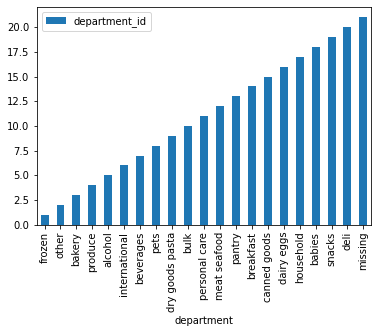

In [15]:
display(departments.head( ))
display(departments.info())
departments.plot(x ='department', y='department_id', kind = 'bar')


In [16]:
departments.describe()

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


## Products

In [17]:
# pr(products)

In [18]:
display(products.info())
display(products.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


None

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [19]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


## Previous Orders

In [20]:
# pr(orders_prior)

In [21]:
display(orders_prior.info())
display(orders_prior.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


None

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [22]:
orders_prior.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


## Orders

In [23]:
# pr(orders)

In [24]:
display(orders.info())
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


None

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [25]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


<IPython.core.display.Javascript object>

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,16,Mint Chocolate Flavored Syrup,103,19,snacks
2,25,Salted Caramel Lean Protein & Fiber Bar,3,19,snacks
3,32,Nacho Cheese White Bean Chips,107,19,snacks
4,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,snacks


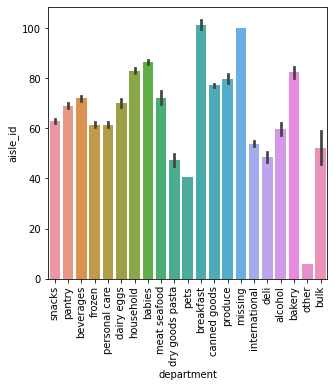

In [26]:
df1 = pd.merge(products,departments,on = 'department_id')
display(df1.head())

plt.figure(figsize =(5,5))
plt.xticks(rotation = 90)
ax = sns.barplot(x = 'department',y ='aisle_id' ,data = df1)


as we see above there is a wide variety of things that users want. Most notably is the babies and breakfast aisles that people order the most, even though they aren't surprising in the least. Babies need a lot of attention and it is hard to go out to the stores when taking care of them and with the breakfast aisle who really wants to go out everyday and get breakfast . the missing section is pretty large too and I assume that it is mostly for things that they couldn't classify in the 20 other categories. We will take a look at that next

In [27]:
missing = df1[df1['department']=='missing']
missing.head(25)

,product_id,product_name,aisle_id,department_id,department
42813,38,Ultra Antibacterial Dish Liquid,100,21,missing
42814,72,Organic Honeycrisp Apples,100,21,missing
42815,110,Uncured Turkey Bologna,100,21,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing
42818,437,Strawberry Cheesecake Nonfat Yogurt,100,21,missing
42819,440,Crossovers Olive Thyme Almond,100,21,missing
42820,472,Fancy Diced Hot Chilies,100,21,missing
42821,491,Pompelmo Water,100,21,missing
42822,556,Bake & Break Cheese Garlic Loaf,100,21,missing



Looking at the data inside of the missing category it looks like it is a bunch of different items from different categories that the data was not able to find the correct departments

In [28]:
orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [29]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


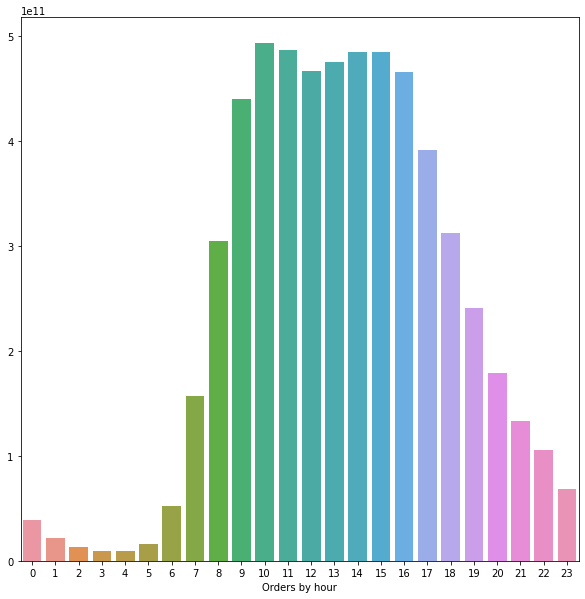

In [30]:
orders.head()
orders = orders.fillna(0)
time_df = orders.groupby('order_hour_of_day')['order_id'].sum().reset_index()
plt.figure(figsize = (10,10))
plots = sns.barplot(x ='order_hour_of_day',y = 'order_id',data = time_df)
plots.set(xlabel = 'Orders by hour',ylabel = '')
plt.savefig('Pictures/order_hour.jpeg')

As we see above the most orders that people make are within business hours. That would be a normal thing in my eyes because all stores are open in the time frame of 6 am to about 10 pm. Even though most stores aren't open in the times between 11 pm to 5 am that wouldn't stop people from ordering since when the stores first open up their orders will be done by the time the morning rush hits.

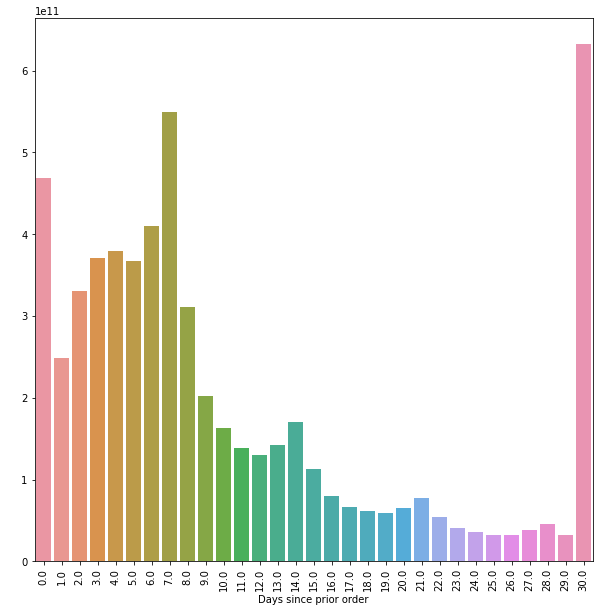

In [31]:
older_orders = orders.groupby('days_since_prior_order')['order_id'].sum().reset_index()
plt.figure(figsize = (10,10))
plt.xticks(rotation = 90)
plots =sns.barplot(x = 'days_since_prior_order',y='order_id',data = older_orders)
plots.set(xlabel = 'Days since prior order',ylabel = " ")
plt.savefig('Pictures/Days_since_prior_order.jpeg',bbox_inches = 'tight')

as we can see, a lot of people make orders going from the last day of the month into the first week of the month. This is logical considering that it is easier to just get everything at the beginning of the month and just order what you need throughout the rest of the month when the items are used up

## Data Check
with the preliminary checks of the datasets done we will be going into looking at the entirety of the dataset. Initially I am interested in the data about the departments and aisles in regards to what products are most popular.

Checking the top 10 departments of the data

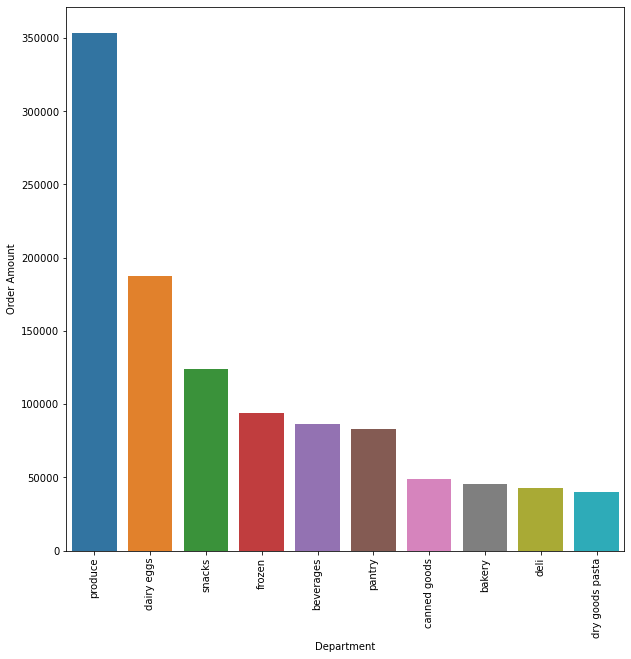

In [32]:
department_share = grocery.groupby('department')['add_to_cart_order'].sum().sort_values(ascending = False).reset_index()[0:10]
plt.figure(figsize = (10,10))
plt.xticks(rotation = 90)

ax = sns.barplot(x ='department',y = 'add_to_cart_order' ,data = department_share)
ax.set(xlabel = 'Department',ylabel = 'Order Amount')
plt.savefig('Pictures/Departments.png')

Checking to see the percentage of each departments according to sales

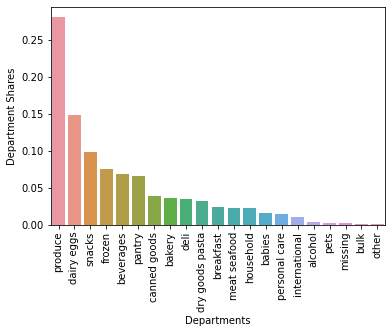

In [33]:
depart = grocery.groupby('department')['add_to_cart_order'].sum().reset_index()
depart['sales_percentage'] = depart['add_to_cart_order']
depart['sales_percentage'] = depart['sales_percentage'].apply(lambda x:x /depart['add_to_cart_order'].sum())

plots = sns.barplot(data = depart.sort_values(by = 'sales_percentage',ascending = False),x = 'department',y = 'sales_percentage')
plt.xticks(rotation = 90)
plots.set(xlabel = 'Departments',ylabel = 'Department Shares')
plt.savefig('Pictures/Department_percentages.jpeg',bbox_inches='tight')

Popular aisles based on orders

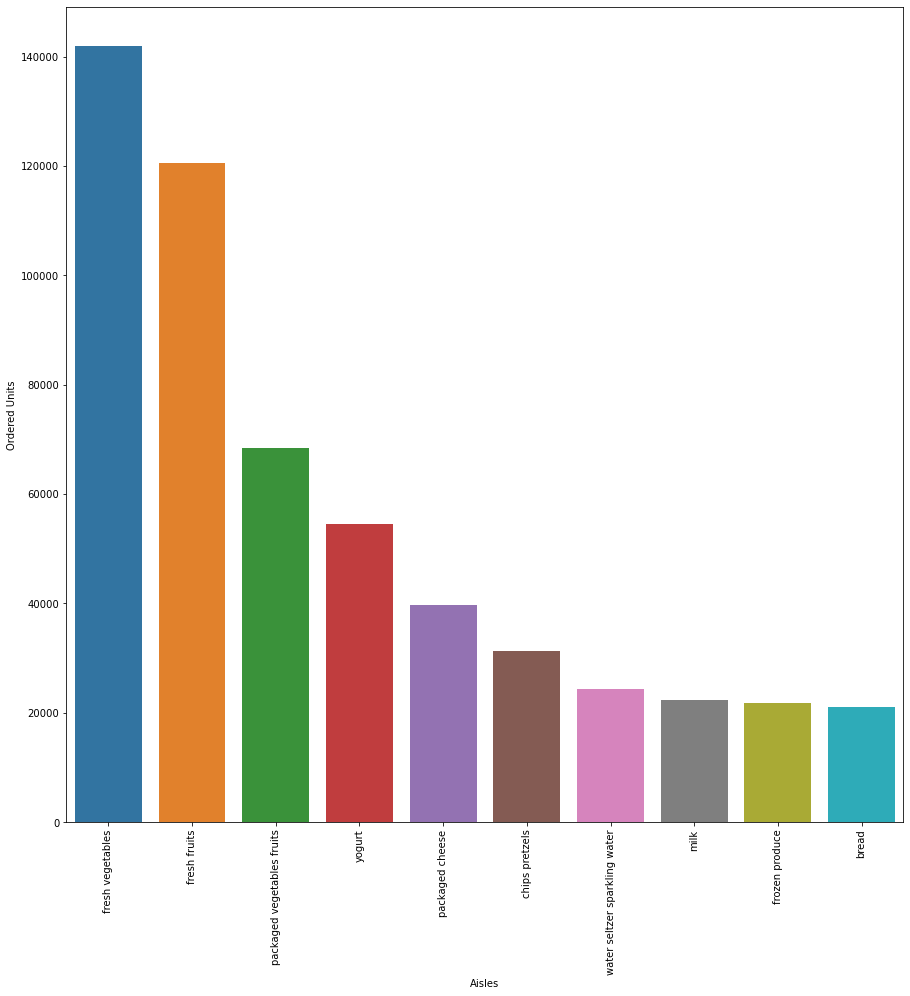

In [34]:
plt.figure(figsize = (15,15))
x = sns.barplot(data = grocery.groupby('aisle')['add_to_cart_order'].sum().sort_values(ascending = False)
                .sort_values(ascending = False).reset_index()[0:10],x = 'aisle',y ='add_to_cart_order')
plt.xticks(rotation = 90)

x.set(xlabel = 'Aisles',ylabel = 'Ordered Units')
plt.savefig('Pictures/Products.png',bbox_inches='tight')

Top 30 most purchased product by name

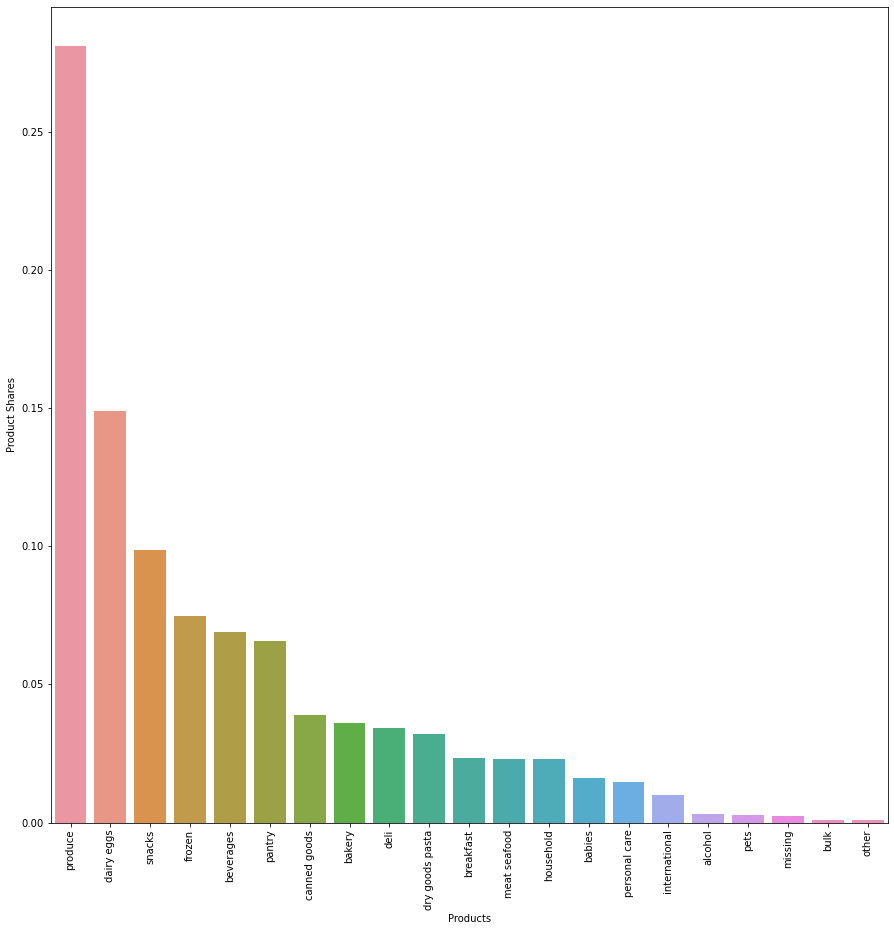

In [35]:
aisl = grocery.groupby('department')['add_to_cart_order'].sum().reset_index()
aisl['sales_percentage'] = aisl['add_to_cart_order']
aisl['sales_percentage'] = aisl['sales_percentage'].apply(lambda x:x /aisl['add_to_cart_order'].sum())
plt.figure(figsize = (15,15))
plot = sns.barplot(data = aisl.sort_values(by = 'sales_percentage',ascending = False)[0:30],x = 'department',y = 'sales_percentage')

plt.xticks(rotation = 90)
plot.set(xlabel = 'Products',ylabel = 'Product Shares')
plt.savefig('Pictures/Products_percentages.png',bbox_inches='tight')

### Distribution of orders by customers

In [36]:
grocery.groupby('user_id')['order_id'].nunique().describe()

count    82019.000000
mean         1.772480
std          1.302103
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         18.000000
Name: order_id, dtype: float64

[Text(0.5, 0, 'Orders by User')]

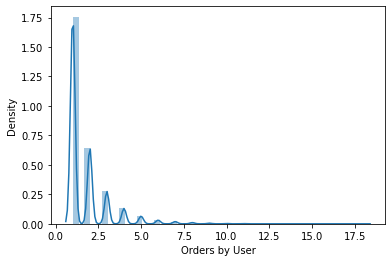

In [37]:
x = sns.distplot(grocery.groupby('user_id')['order_id'].nunique())
x.set(xlabel = 'Orders by User')

[Text(0.5, 0, 'Units ordered by User')]

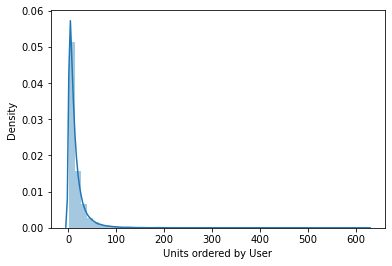

In [38]:
#number of products ordered by user over the year
x = sns.distplot(grocery.groupby('user_id')['add_to_cart_order'].sum())
x.set(xlabel = 'Units ordered by User')

In [39]:
#order size summary
grocery.groupby('order_id')['add_to_cart_order'].sum().describe()

count    145377.000000
mean          8.652889
std           7.831434
min           1.000000
25%           3.000000
50%           6.000000
75%          12.000000
max         152.000000
Name: add_to_cart_order, dtype: float64

[Text(0.5, 0, 'Units per order')]

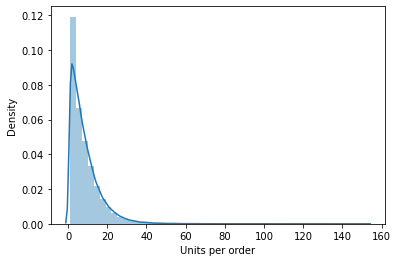

In [40]:
# number of unites per order over view

x = sns.distplot(grocery.groupby('order_id')['add_to_cart_order'].sum())
x.set(xlabel='Units per order')

[Text(0.5, 0, 'Units per order')]

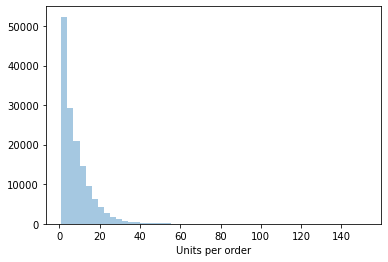

In [41]:
order_size = grocery.groupby('order_id')['add_to_cart_order'].sum().reset_index()

x = sns.distplot(order_size[order_size.add_to_cart_order <500]['add_to_cart_order'],kde = False)
x.set(xlabel = 'Units per order')

In [42]:
# order statistics

orders.groupby('user_id')['days_since_prior_order'].mean().describe()

count    206209.000000
mean         13.428600
std           5.496185
min           0.000000
25%           9.000000
50%          13.320000
75%          17.687500
max          27.000000
Name: days_since_prior_order, dtype: float64

[Text(0.5, 0, 'Average Days Between Orders By User')]

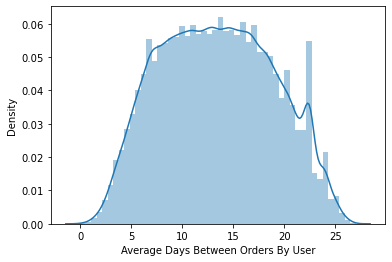

In [43]:
# time between orders
x = sns.distplot(orders.groupby('user_id')['days_since_prior_order'].mean())
x.set(xlabel = 'Average Days Between Orders By User')

# Model:


## Model Preprocessing

In [44]:
users_items = grocery[grocery.duplicated(subset = ['user_id','product_id'],keep = 'first')]
#started at 9:20pm

In [45]:
# data = []
# columns = ['user_id','product_id','count']
# for user in users_items.user_id.unique():
#     counts = users_items[users_items['user_id'] == user].product_id.value_counts()
#     for i in range(len(counts)):
#         data.append([user,counts.index[i],counts.values[i]])


#started at 9:25pm ended at 11:30 pm not going to run this again for sake of computational resources

In [46]:
# rec_df = pd.DataFrame(data,columns = columns)
# rec_df
# rec_df.to_csv('rec_df.csv')

In [47]:
rec_df = pd.read_csv('Application/rec_df.csv').sample(150000,random_state = 123)
rec_df.drop(['Unnamed: 0'],axis = 1,inplace = True)

<IPython.core.display.Javascript object>

In [48]:
rec_df.head()

,user_id,product_id,count
3524309,142168,5876,3
2230406,124740,40706,2
2238939,199398,14531,1
3453532,153079,44091,1
885257,30822,23909,22


## Recommendation System
for my computers computational sake I will be sampling the data at 150,000

In [49]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.prediction_algorithms import SVD, SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [50]:
reader = Reader(rating_scale=(1,100))
rec_data = Dataset.load_from_df(rec_df,reader)

trainset,testset = train_test_split(rec_data,test_size = .2, random_state = 123)

In [51]:
svd = SVD()
svd.fit(trainset)

In [52]:
svd_pred = svd.test(testset)

accuracy.rmse(svd_pred)

RMSE: 4.7514


4.751395371949943

Initial gridsearch

In [53]:
# param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1)
# gs_model.fit(rec_data)
#started 10:23am ended at 10:35

In [54]:
# gs_model.best_params

#'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4},
#  'mae': {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}

In [55]:
rec_df['user_id']

3524309    142168
2230406    124740
2238939    199398
3453532    153079
885257      30822
            ...  
2331735    164482
1652913      8925
4804719    163674
1126881    164799
1011980      5286
Name: user_id, Length: 150000, dtype: int64

In [56]:
rec_df[rec_df['user_id'] == 8925]

,user_id,product_id,count
1652860,8925,27104,6
1652913,8925,19048,1


In [57]:
uid = 8925
iid = 27104
pred = svd.predict(uid,iid,r_ui = 6,verbose = True)

user: 8925       item: 27104      r_ui = 6.00   est = 3.63   {'was_impossible': False}


In [58]:
testset[0]

(164720, 6873, 1.0)

In [59]:
pred = svd.predict(169473,13176,r_ui =1,verbose = True)

user: 169473     item: 13176      r_ui = 1.00   est = 6.31   {'was_impossible': False}


In [60]:
svd_best = SVD(n_factors=100, n_epochs = 10, lr_all = 0.005, reg_all = 0.6)
svd_best.fit(trainset)
svd_best_pred = svd_best.test(testset)

accuracy.rmse(svd_best_pred)

#n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6

RMSE: 4.7610


4.7609530543320275

In [61]:
testset[-1]

(24674, 21386, 1.0)

In [62]:
pred = svd.predict(179920, 24838, r_ui = 16.0,verbose = True)

user: 179920     item: 24838      r_ui = 16.00   est = 5.47   {'was_impossible': False}


Looking at the above user, it shows that after a certain point the classifier heavily misclassifies the users with higher amounts of products "ratings" ie the amount they purchased. What we will do is assume that if they are getting anything more then 5 of them that they really like the product so we will be changing the 'rating' category to a 1 to 5 list. anything that is below a 5 is going to stay the same and anything that is a 5 or more will be changed to a straight 5 for the classifier

In [63]:
rec_df['rating'] = rec_df['count'].apply(lambda x: 5 if (x>5) else x)

(array([61816.,     0., 29059.,     0.,     0., 16658.,     0., 10329.,
            0., 32138.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

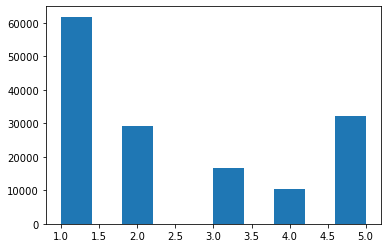

In [64]:
plt.hist(rec_df['rating'])

In [65]:
new_rec_df = rec_df.drop('count',axis = 1)

new reader

In [66]:
reader = Reader(rating_scale =(1,5))
new_rec_data = Dataset.load_from_df(new_rec_df,reader)


In [67]:
new_trainset,new_testset = train_test_split(new_rec_data,test_size = .2,random_state = 123)

In [68]:
new_svd = SVD(n_factors = 100,n_epochs = 10,lr_all = .005,reg_all = .6)

In [69]:
new_svd.fit(new_trainset)
new_pred = new_svd.test(new_testset)

In [70]:
accuracy.rmse(new_pred)

RMSE: 1.5484


1.5484396568230572

In [71]:
new_testset[0]

(164720, 6873, 1.0)

In [72]:
new_rec_df[new_rec_df['user_id'] ==164720 ]

,user_id,product_id,rating
2417864,164720,6873,1
2417867,164720,19678,1


In [73]:
uid = 164720
iid = 6873
pred = new_svd.predict(uid,iid,r_ui = 1,verbose = True)

user: 164720     item: 6873       r_ui = 1.00   est = 2.66   {'was_impossible': False}


In [74]:
new_testset[1]

(21837, 16291, 5.0)

In [75]:
new_rec_df[new_rec_df['user_id'] == 21837]

,user_id,product_id,rating
3670601,21837,16291,5


In [76]:
uid = 21837
iid = 16291
pred = new_svd.predict(uid,iid,r_ui = 5,verbose = True)

user: 21837      item: 16291      r_ui = 5.00   est = 2.53   {'was_impossible': False}


Based off the new user SVD model parameters it looks like the rough estimated values of the rmse is correct and roughly around a 1.54 error. which is what we would expect

In [ ]:
from collections import defaultdict

def get_top_n(predictions,n = 10):
    top_n = defaultdict(list)
    #map the predictions to each user
    for uid,iid,true_r,est, _ in predictions:
        top_n[uid].append((iid,est))
    # Then sort the predictions for each user and retrieve the k highest ones
    for uid,user_ratings in top_n.items():
        user_ratings.sort( key = lambda x:x[1],reverse =True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [ ]:
top_n = get_top_n(new_svd_best_predictions,n = 10)

In [ ]:
def grocery_rater(df, num, aisle=None):
    userID = 300000
    rating_list = []
    while num > 0:
        if aisle:
            product = df[df['aisle'].str.contains(aisle)].sample(1)
        else:
            product = df.sample(1)
        print('\n', product['product_name'].iloc[0])
        rating = input('How do you rate this product on a scale of 1-5, choose 0 to rate a different product:\n')
        if rating == '0':
            continue
        else:
            rating_one_product = {'user_id':userID,'product_id':product['product_id'].iloc[0],'rating':int(rating)}
            rating_list.append(rating_one_product) 
            num -= 1
    return rating_list

In [ ]:
df = pd.merge(products,aisles, on = 'aisle_id',how = 'left')
products_desc = pd.merge(df,departments,on = 'department_id',how = 'left')


In [ ]:
user_rating = grocery_rater(products_desc, 4, aisle='candy')

In [ ]:
short_head = list(new_rec_df.product_id.value_counts()[:6207].cumsum().index)

In [ ]:
new_ratings_df = new_rec_df.append(user_rating, ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [ ]:
new_user_svd = SVD(n_factors = 20, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)
new_user_svd.fit(new_data.build_full_trainset())

In [ ]:
list_of_products = []
for product in new_ratings_df['product_id'].unique():
    product_name = products_desc[products_desc['product_id'] == product]['product_name'].iloc[0]
    product_aisle = products_desc[products_desc['product_id'] == product]['aisle'].iloc[0]
    list_of_products.append((product, new_user_svd.predict(300000, product)[3], product_name, product_aisle))

In [ ]:
ranked_products = sorted(list_of_products, key=lambda x:x[1], reverse=True)

In [ ]:
def recommended_products(ranked_products, n, aisle=None):
    for idx, rec in enumerate(ranked_products):
        if aisle:    
            if aisle in rec[3]: 
                name = rec[2]
                print('Recommendation # ', idx+1, ': ', name, '\n')
                n-= 1
            elif idx == len(ranked_products)-1:
                print('No recommended products found')
                continue
        else:
            name = rec[2]
            print('Recommendation # ', idx+1, ': ', name, '\n')
            n-= 1
        if n == 0:
            break

In [ ]:
def recommend_diverse_products(ranked_products, n, aisle=None, percent_diverse=.20):
    
    num_diverse = round(n * percent_diverse)
    recs = []
    
    if n < 1:
        print('Number of recommended products must be 1 or more')
        return recs
    
    for idx, rec in enumerate(ranked_products):
        
        if n == 0:
            return recs
            
        prod_id, rating, prod_name, aisle_name = [*rec]
        
               
        if aisle:                                    # Did we specify an aisle? 
            if aisle in aisle_name:                  # Is it in the aisle we want?
                if n > num_diverse:                  # Are we looking for a long tail product? No
                    name = prod_name
                    print('Recommendation # ', idx+1, ': ', name, '\n')
                    recs.append(rec)
                    n-= 1
                else:                                 # Are we looking for a long tail product? Yes
                    if prod_id not in short_head:     # Is it NOT in the short_head list?
                        name = prod_name
                        print('Recommendation # ', idx+1, ': ', name, '\n')
                        recs.append(rec)
                        n-= 1
                    else:
                        continue
            elif idx == len(ranked_products)-1:
                print('No recommended products found')
                continue
        else:
            if n > num_diverse:                  # Are we looking for a long tail product? No
                name = prod_name
                print('Recommendation # ', idx+1, ': ', name, '\n')
                recs.append(rec)
                n-= 1
            else:                                 # Are we looking for a long tail product? Yes
                if prod_id not in short_head:     # Is it NOT in the short_head list?
                    name = prod_name
                    print('Recommendation # ', idx+1, ': ', name, '\n')
                    recs.append(rec)
                    n-= 1
                else:
                    continue

In [ ]:
def generate_new_user_recommendations(new_rec_df, products_desc, n_to_rate, n_to_rec, percent_diverse, 
                                      rate_aisle=None, rec_aisle=None):
    
    # Get user ratings
    user_rating = grocery_rater(products_desc, n_to_rate, aisle=rate_aisle)
    
    ## add the new ratings to the original ratings DataFrame
    print('Creating ratings dataset...')
    new_ratings_df = new_rec_df.append(user_rating, ignore_index=True)
    new_data = Dataset.load_from_df(new_ratings_df, reader)
    
    # train a model using the new combined DataFrame
    print('Training recommendation model...')
    new_user_svd = SVD(n_factors = 20, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)
    new_user_svd.fit(new_data.build_full_trainset())
    
    # make predictions for the user
    print('Making predictions...')
    list_of_products = []
    for product in new_ratings_df['product_id'].unique():
        product_name = products_desc[products_desc['product_id'] == product]['product_name'].iloc[0]
        product_aisle = products_desc[products_desc['product_id'] == product]['aisle'].iloc[0]
        list_of_products.append((product, new_user_svd.predict(300000, product)[3], product_name, product_aisle))
    
    # order the predictions from highest to lowest rated
    ranked_products = sorted(list_of_products, key=lambda x:x[1], reverse=True)
    
    # return the top n recommendation
    return recommend_diverse_products(ranked_products, n_to_rec, aisle=rec_aisle, percent_diverse=percent_diverse)

In [ ]:
recs = recommend_diverse_products(ranked_products, 10, percent_diverse=1)

In [ ]:
recs

In [ ]:
generate_new_user_recommendations(new_rec_df, products_desc, n_to_rate=5, n_to_rec=6, 
                                  percent_diverse=1, rate_aisle='meat', rec_aisle=None)

# Interpret results:

    
    

Results:
- Clustering data is great for market segmentation and target marketing.
- The SVD Model did great after we lowered the scale down to 1-5 compaired to the 1-100
- Popularity skewed the data a bit but we fixed it by rerunning the recommendations after getting more knowledge of the user.

Next-steps/ Future Work:
- Go back and recluster to see if we can get better results by upping the number of clusters there are and make the bigger clusters smaller
- Generate keywords on the items to create and operate a search function by products.
- Create an external database to offload the data from local machine to make the program run faster and operate the application better and recommend on the full dataset. As stated above computational power for application
- Impliment an efficient-apriori algorithm to find and create associations with certain items like bread,eggs usually go with bacon